## Implementing the paper 'Attention is all you need'

Transformer architecture

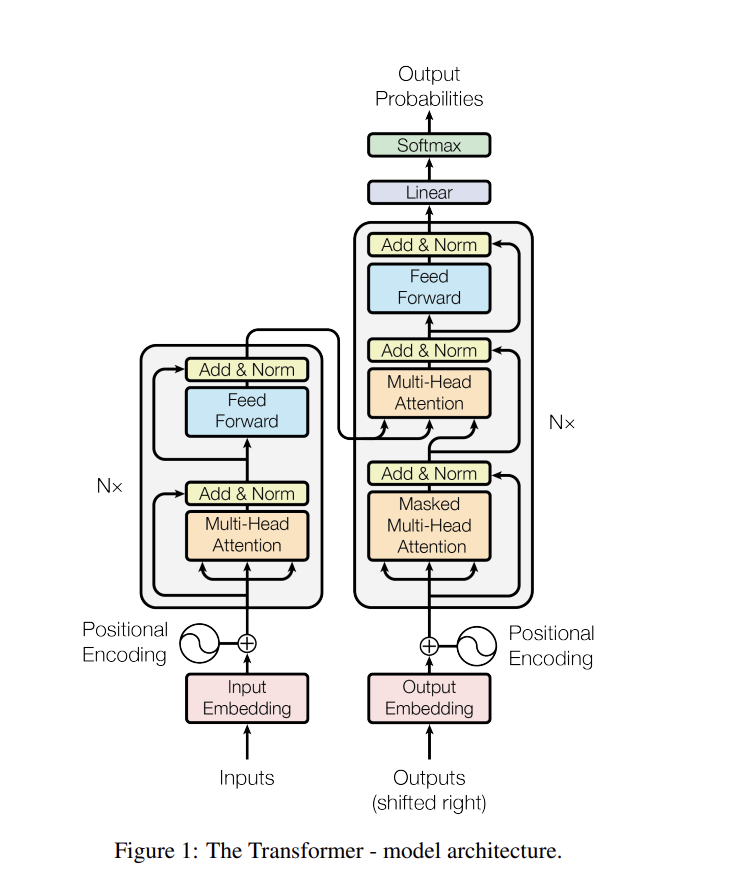

The first approach would be to replicate the above as it is. I will use charachter level encodings instead of word encodings and try to replicate the OpenWebText dataset available at https://www.kaggle.com/datasets/himonsarkar/openwebtext-dataset?select=val_split.txt

## Imports 

In [1]:
import torch
import pandas as pd 
import numpy as np 
import os 
import re
import sys 
from utils import *

## Extracting the data

In [2]:
# Reading the text and file and viewing some of the data
with open('./val_split.txt', 'r', encoding='utf-8') as fil: 
    text = fil.read(500*1024*1024)

In [3]:
print("There are {} characters in the dataset.".format(str(len(text))))
print("\n\nThe first 1000 characters are: \n{}".format(text[:1000]))

There are 524288000 characters in the dataset.


The first 1000 characters are: 
0596042-09acc044538ae76635c0719f2788efbd.txt                                                        0000644 0000000 0000000 00000003267 00000000000 015061  0                                                                                                    ustar                                                                   0000000 0000000                                                                                                                                                                        Amazon's Echo speakers. James Cook/BI

Tech companies seem determined to make smart glasses work.

Amazon is the latest firm to try to build its own smart spectacles, secretly working on a pair of glasses which lets you summon Alexa while wearing them, according to The Financial Times.

The glasses would need to be wirelessly connected to a smartphone to work, and apparently look like normal spectacles. 

In [22]:
# Cleaning the text
clean_text = re.sub(r'[^\x20-\x7E]', '', text)
clean_text[116:500]

"Amazon's Echo speakers. James Cook/BITech companies seem determined to make smart glasses work.Amazon is the latest firm to try to build its own smart spectacles, secretly working on a pair of glasses which lets you summon Alexa while wearing them, according to The Financial Times.The glasses would need to be wirelessly connected to a smartphone to work, and apparently look like no"

In [23]:
with open('./subset.txt', 'w', encoding='utf-8') as fil: 
    fil.write(clean_text[116:])

In [24]:
with open('./subset.txt', 'r') as fil: 
    text = fil.read()
text[:1000]

"Amazon's Echo speakers. James Cook/BITech companies seem determined to make smart glasses work.Amazon is the latest firm to try to build its own smart spectacles, secretly working on a pair of glasses which lets you summon Alexa while wearing them, according to The Financial Times.The glasses would need to be wirelessly connected to a smartphone to work, and apparently look like normal spectacles. That's a change from Google Glass, which never took off with consumers in part because they looked so unappealing.Amazon's device uses bone conduction so that wearers can hear Alexa clearly, according to the report. And they could be released by the end of this year.Amazon did not immediately respond to Business Insider's request for comment.Google Glass was unappealing. ReutersMoving Alexa to smart glasses would untether Amazon's smart assistant, which has largely been limited to the home. You can talk to Alexa on Amazon's Echo speakers, or smart fridges, lamps, and other home items. The as